# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

#acc_drop = metadata[metadata["genotype"] == "rpoC G17D"]["Run"].tolist()
#acc_drop = [acc + "_sorted.bam" for acc in acc_drop]
#df_initial.drop(columns=acc_drop, inplace=True)
#metadata = metadata[metadata['genotype'] == 'WT']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR1555229_sorted.bam,SRR1555228_sorted.bam,SRR1555225_sorted.bam,SRR1555222_sorted.bam,SRR1555226_sorted.bam,SRR1555230_sorted.bam,SRR1555224_sorted.bam,SRR1555220_sorted.bam,SRR1555221_sorted.bam,SRR1555227_sorted.bam,SRR1555223_sorted.bam,SRR1555231_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-MSMEI_RS00005,NC_018289.1,1,1515,+,1515,3,3,33,26,3,0,14,81,137,10,141,5
gene-MSMEI_RS00010,NC_018289.1,2109,3302,+,1194,6,4,21,42,6,1,10,57,142,22,69,2
gene-MSMEI_RS00015,NC_018289.1,3331,4224,+,894,2,1,11,18,2,0,5,55,89,11,59,2
gene-MSMEI_RS00020,NC_018289.1,4234,5388,+,1155,3,4,4,6,1,3,17,43,57,7,58,1
gene-MSMEI_RS00025,NC_018289.1,5385,5969,+,585,0,0,2,3,0,0,0,15,17,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PBI_KAMPY_84,KJ510414.1,48594,48806,-,213,35,21,3347,58,121,172,1847,0,0,167,442,273
gene-PBI_KAMPY_85,KJ510414.1,48803,48901,-,99,50,18,2031,23,56,247,1133,0,0,174,173,187
gene-PBI_KAMPY_86,KJ510414.1,48901,49107,-,207,55,26,1711,62,95,256,922,0,0,251,288,265


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time,treatment
0,SRR1555220,RNA-Seq,81,33732000,PRJNA258602,SAMN03000688,26558029,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684365,GSM1482965,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482965,Uninfected culture,SRP045668,0 minutes,uninfected
1,SRR1555221,RNA-Seq,96,46025545,PRJNA258602,SAMN03000689,36280087,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684366,GSM1482966,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482966,Uninfected culture,SRP045668,0 minutes,uninfected
2,SRR1555222,RNA-Seq,75,24576376,PRJNA258602,SAMN03000690,20888805,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684367,GSM1482967,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482967,Infected culture,SRP045668,5 minutes,A4 mycobacteriophage
3,SRR1555223,RNA-Seq,103,70165316,PRJNA258602,SAMN03000691,58359179,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684368,GSM1482968,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482968,Infected culture,SRP045668,5 minutes,A4 mycobacteriophage
4,SRR1555224,RNA-Seq,127,27605398,PRJNA258602,SAMN03000692,23045519,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684369,GSM1482969,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:58:00Z,1,GSM1482969,Infected culture,SRP045668,15 minutes,A4 mycobacteriophage
5,SRR1555225,RNA-Seq,141,47380983,PRJNA258602,SAMN03000693,37888386,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684370,GSM1482970,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482970,Infected culture,SRP045668,15 minutes,A4 mycobacteriophage
6,SRR1555226,RNA-Seq,101,9797163,PRJNA258602,SAMN03000694,7702313,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684371,GSM1482971,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482971,Infected culture,SRP045668,30 minutes,A4 mycobacteriophage
7,SRR1555227,RNA-Seq,110,56214298,PRJNA258602,SAMN03000695,42496665,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684372,GSM1482972,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482972,Infected culture,SRP045668,30 minutes,A4 mycobacteriophage
8,SRR1555228,RNA-Seq,94,34788388,PRJNA258602,SAMN03000696,28504392,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684373,GSM1482973,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482973,Infected culture,SRP045668,60 minutes,A4 mycobacteriophage
9,SRR1555229,RNA-Seq,93,36809301,PRJNA258602,SAMN03000697,28943961,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684374,GSM1482974,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482974,Infected culture,SRP045668,60 minutes,A4 mycobacteriophage


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM1482965': '0_R1',  'GSM1482966': '0_R2',
              'GSM1482967': '5_R1',  'GSM1482968': '5_R2',
              'GSM1482969': '15_R1',  'GSM1482970': '15_R2',
              'GSM1482971': '30_R1',  'GSM1482972': '30_R2',
              'GSM1482973': '60_R1',  'GSM1482974': '60_R2',
              'GSM1482975': '120_R1',  'GSM1482976': '120_R2'
              
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time,treatment
0,SRR1555220,RNA-Seq,81,33732000,PRJNA258602,SAMN03000688,26558029,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684365,GSM1482965,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482965,Uninfected culture,SRP045668,0 minutes,uninfected


In [9]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR1555220_sorted.bam,SRR1555220,RNA-Seq,81,33732000,PRJNA258602,SAMN03000688,26558029,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684365,GSM1482965,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482965,Uninfected culture,SRP045668,0 minutes,uninfected,SRR1555220_sorted.bam,0_R1
SRR1555221_sorted.bam,SRR1555221,RNA-Seq,96,46025545,PRJNA258602,SAMN03000689,36280087,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684366,GSM1482966,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482966,Uninfected culture,SRP045668,0 minutes,uninfected,SRR1555221_sorted.bam,0_R2
SRR1555222_sorted.bam,SRR1555222,RNA-Seq,75,24576376,PRJNA258602,SAMN03000690,20888805,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684367,GSM1482967,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482967,Infected culture,SRP045668,5 minutes,A4 mycobacteriophage,SRR1555222_sorted.bam,5_R1
SRR1555223_sorted.bam,SRR1555223,RNA-Seq,103,70165316,PRJNA258602,SAMN03000691,58359179,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684368,GSM1482968,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:57:00Z,1,GSM1482968,Infected culture,SRP045668,5 minutes,A4 mycobacteriophage,SRR1555223_sorted.bam,5_R2
SRR1555224_sorted.bam,SRR1555224,RNA-Seq,127,27605398,PRJNA258602,SAMN03000692,23045519,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX684369,GSM1482969,Ion Torrent PGM,SINGLE,cDNA,TRANSCRIPTOMIC,Mycobacterium smegmatis,ION_TORRENT,2015-02-04T00:00:00Z,2014-08-21T10:58:00Z,1,GSM1482969,Infected culture,SRP045668,15 minutes,A4 mycobacteriophage,SRR1555224_sorted.bam,15_R1


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2',
         '5_R1', '5_R2',
         '15_R1', '15_R2',
         '30_R1', '30_R2',
         '60_R1', '60_R2',
         '120_R1', '120_R2']]
df.head()

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2
Geneid,,,,,,,,,,,,
gene-MSMEI_RS00005,81,137,26,141,14,33,3,10,3,3,0,5
gene-MSMEI_RS00010,57,142,42,69,10,21,6,22,4,6,1,2
gene-MSMEI_RS00015,55,89,18,59,5,11,2,11,1,2,0,2
gene-MSMEI_RS00020,43,57,6,58,17,4,1,7,4,3,3,1
gene-MSMEI_RS00025,15,17,3,2,0,2,0,0,0,0,0,0


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/KJ510414.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "KJ510414.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
6594,KJ510414.1,Genbank,gene,538.0,765.0,.,+,.,gene-PBI_KAMPY_1,1,Gene,protein_coding,PBI_KAMPY_1,1,HNH endonuclease,HNH endonuclease,333.0,"DNA, RNA and nucleotide metabolism"
6595,KJ510414.1,Genbank,gene,803.0,1234.0,.,+,.,gene-PBI_KAMPY_2,2,Gene,protein_coding,PBI_KAMPY_2,2,hypothetical protein,minor tail protein,226.0,tail
6596,KJ510414.1,Genbank,gene,1327.0,1641.0,.,+,.,gene-PBI_KAMPY_3,3,Gene,protein_coding,PBI_KAMPY_3,3,hypothetical protein,hypothetical protein,1126.0,unknown function
6597,KJ510414.1,Genbank,gene,1646.0,2719.0,.,+,.,gene-PBI_KAMPY_4,4,Gene,protein_coding,PBI_KAMPY_4,4,hypothetical protein,tail protein,819.0,tail
6598,KJ510414.1,Genbank,gene,2723.0,3385.0,.,+,.,gene-PBI_KAMPY_5,5,Gene,protein_coding,PBI_KAMPY_5,5,hypothetical protein,minor tail protein,356.0,tail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,KJ510414.1,Genbank,gene,48594.0,48806.0,.,-,.,gene-PBI_KAMPY_84,84,Gene,protein_coding,PBI_KAMPY_84,84,hypothetical protein,hypothetical protein,2464.0,unknown function
6678,KJ510414.1,Genbank,gene,48803.0,48901.0,.,-,.,gene-PBI_KAMPY_85,85,Gene,protein_coding,PBI_KAMPY_85,85,hypothetical protein,hypothetical protein,2001.0,unknown function
6679,KJ510414.1,Genbank,gene,48901.0,49107.0,.,-,.,gene-PBI_KAMPY_86,86,Gene,protein_coding,PBI_KAMPY_86,86,hypothetical protein,hypothetical protein,2246.0,unknown function
6680,KJ510414.1,Genbank,gene,49130.0,50014.0,.,-,.,gene-PBI_KAMPY_87,87,Gene,protein_coding,PBI_KAMPY_87,87,hypothetical protein,hypothetical protein,1617.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'KJ510414.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [14]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-MSMEI_RS00005,NC_018289.1,RefSeq,gene,1.0,1515.0,.,+,.,ID=gene-MSMEI_RS00005;Name=dnaA;gbkey=Gene;gen...,gene-MSMEI_RS00005,protein_coding,dnaA,host
gene-MSMEI_RS00010,NC_018289.1,RefSeq,gene,2109.0,3302.0,.,+,.,ID=gene-MSMEI_RS00010;Name=dnaN;gbkey=Gene;gen...,gene-MSMEI_RS00010,protein_coding,dnaN,host
gene-MSMEI_RS00015,NC_018289.1,RefSeq,gene,3331.0,4224.0,.,+,.,ID=gene-MSMEI_RS00015;Name=gnd;gbkey=Gene;gene...,gene-MSMEI_RS00015,protein_coding,gnd,host
gene-MSMEI_RS00020,NC_018289.1,RefSeq,gene,4234.0,5388.0,.,+,.,ID=gene-MSMEI_RS00020;Name=recF;gbkey=Gene;gen...,gene-MSMEI_RS00020,protein_coding,recF,host
gene-MSMEI_RS00025,NC_018289.1,RefSeq,gene,5385.0,5969.0,.,+,.,ID=gene-MSMEI_RS00025;Name=MSMEI_RS00025;gbkey...,gene-MSMEI_RS00025,protein_coding,None,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PBI_KAMPY_84,KJ510414.1,Genbank,gene,48594.0,48806.0,.,-,.,ID=gene-PBI_KAMPY_84;Name=84;gbkey=Gene;gene=8...,gene-PBI_KAMPY_84,protein_coding,84,phage
gene-PBI_KAMPY_85,KJ510414.1,Genbank,gene,48803.0,48901.0,.,-,.,ID=gene-PBI_KAMPY_85;Name=85;gbkey=Gene;gene=8...,gene-PBI_KAMPY_85,protein_coding,85,phage
gene-PBI_KAMPY_86,KJ510414.1,Genbank,gene,48901.0,49107.0,.,-,.,ID=gene-PBI_KAMPY_86;Name=86;gbkey=Gene;gene=8...,gene-PBI_KAMPY_86,protein_coding,86,phage


Perform in silico rRNA depletion.

In [15]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2
Geneid,,,,,,,,,,,,
gene-MSMEI_RS32130,3,6,1,2,1,1,0,0,0,1,0,1
gene-MSMEI_RS09540,60,47,19,17,1,0,0,3,3,2,2,1
gene-MSMEI_RS18000,2,4,1,1,0,0,0,0,0,0,0,1
gene-MSMEI_RS33165,1,4,1,5,0,1,0,1,0,1,0,0
gene-MSMEI_RS32755,5,18,3,1,0,0,0,1,1,0,1,0


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [16]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [17]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-MSMEI_RS32130,5.281912,8.185169,3.145067,3.750510,5.764438,2.738338,2.373799,0.496054,1.107971,2.382611,0.506612,1.812537,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,91.526505,59.962026,40.986574,26.318233,5.778636,0.915028,2.379646,3.480931,7.774900,3.980799,2.539298,1.817001,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,6.676206,10.027517,5.565401,3.982063,3.400183,1.615223,4.200593,0.877800,1.960627,1.405395,0.896482,3.207402,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,2.326557,5.824063,3.232430,8.480320,1.974854,2.814403,2.439738,1.529500,1.138748,2.448795,0.520684,0.620962,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,9.179783,25.765148,8.116210,2.488789,2.125115,1.009514,2.625371,1.645875,3.676175,0.878372,1.680905,0.668209,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,835.296675,455.221343,105.883918,287.289060,48.036986,46.551747,21.364195,8.432918,3.323913,18.266684,8.612399,4.229253,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,100.083477,56.056605,51.430268,39.524347,24.438817,4.975462,4.313109,9.914436,2.013144,4.329119,4.602477,1.097772,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,4.071474,0.485339,0.808107,0.578204,1.481140,0.703601,1.829804,1.911875,0.854061,0.612199,1.171540,0.465721,host,gene-MSMEI_RS26155


In [18]:
# Check gene names unique
len(tpms['Symbol'].unique())

6676

Log2+1 normalization raw counts

In [19]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-MSMEI_RS32130,2.000000,2.807355,1.000000,1.584963,1.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,1.0,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,5.930737,5.584963,4.321928,4.169925,1.000000,0.000000,0.000000,2.000000,2.0,1.584963,1.584963,1.0,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,1.584963,2.321928,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,1.000000,2.321928,1.000000,2.584963,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.0,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,2.584963,4.247928,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.0,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,9.113742,8.499846,5.672425,7.584963,3.700440,4.700440,2.321928,3.169925,1.0,3.584963,3.169925,2.0,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,5.209453,4.643856,3.807355,3.906891,2.000000,1.000000,0.000000,2.584963,0.0,1.000000,1.584963,0.0,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.584963,0.0,0.000000,1.000000,0.0,host,gene-MSMEI_RS26155


Log2+1 normalization tpms

In [20]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-MSMEI_RS32130,2.651204,3.199306,2.051395,2.248082,2.757970,1.902397,1.754374,0.581162,1.075855,1.758137,0.591308,1.491872,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,6.531795,5.929839,5.391856,4.771792,2.760995,0.937365,1.756872,2.163798,3.133383,2.316377,1.823463,1.494160,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,2.940393,3.463036,2.714883,2.316743,2.137564,1.386934,2.378676,0.909043,1.565903,1.266274,0.923326,2.072930,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,1.734030,2.770631,2.081486,3.244936,1.572819,1.931457,1.782299,1.338852,1.096766,1.786092,0.604721,0.696850,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,3.347635,4.742284,3.188434,1.802727,1.643909,1.006847,1.858128,1.403745,2.225329,0.909483,1.422720,0.738300,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,9.707871,8.833590,6.739901,8.171372,5.615798,5.571426,4.483119,3.237704,2.112337,4.268036,3.264896,2.386605,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,6.659403,5.834322,5.712328,5.340717,4.668960,2.579050,2.409556,3.448166,1.591269,2.413897,2.486065,1.068858,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,2.342405,0.570792,0.854480,0.658283,1.311003,0.768587,1.500702,1.541948,0.890689,0.689030,1.118718,0.551611,host,gene-MSMEI_RS26155


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [21]:
columnOrder = ['0_R1', '0_R2',
               '5_R1', '5_R2',
               '15_R1', '15_R2',
               '30_R1', '30_R2',
               '60_R1', '60_R2',
               '120_R1', '120_R2']

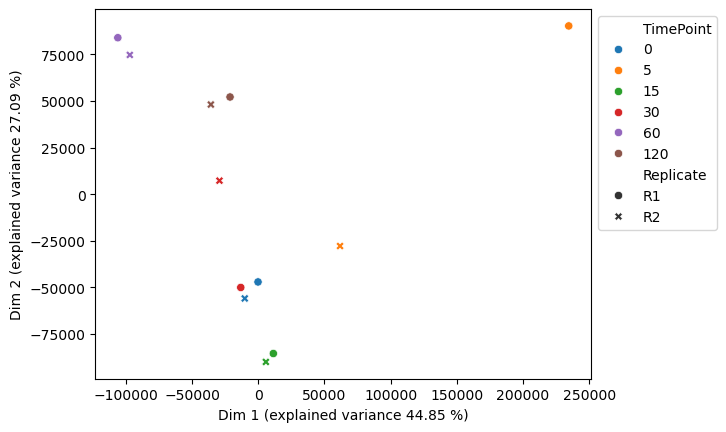

In [22]:
txPCA(tpms[columnOrder])

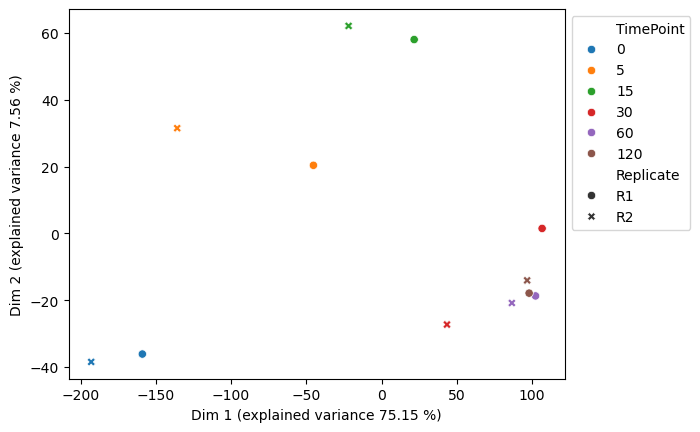

In [23]:
txPCA(logs[columnOrder])

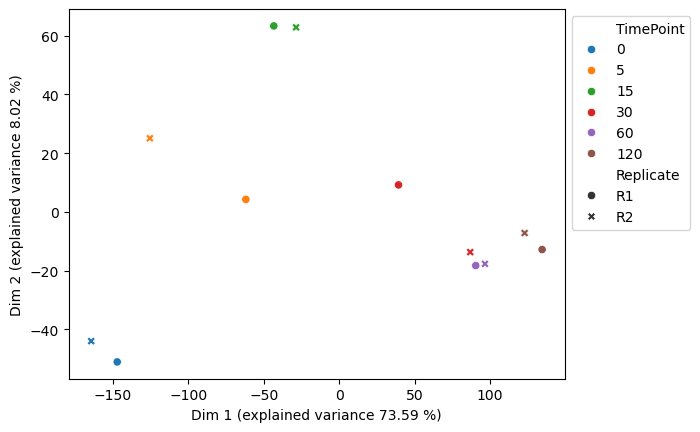

In [24]:
txPCA(logTPMs[columnOrder])

In [25]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

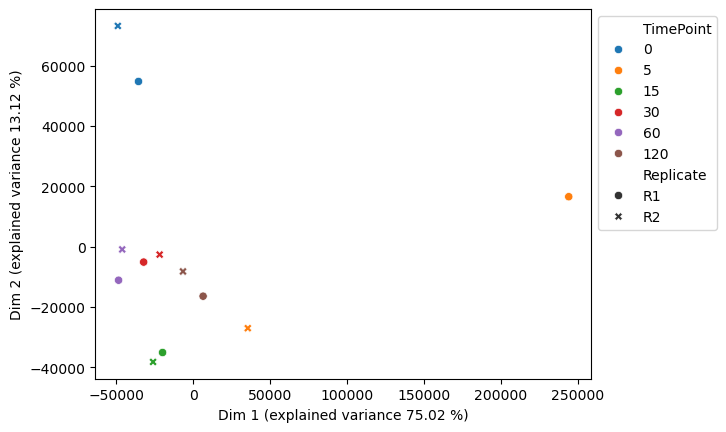

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

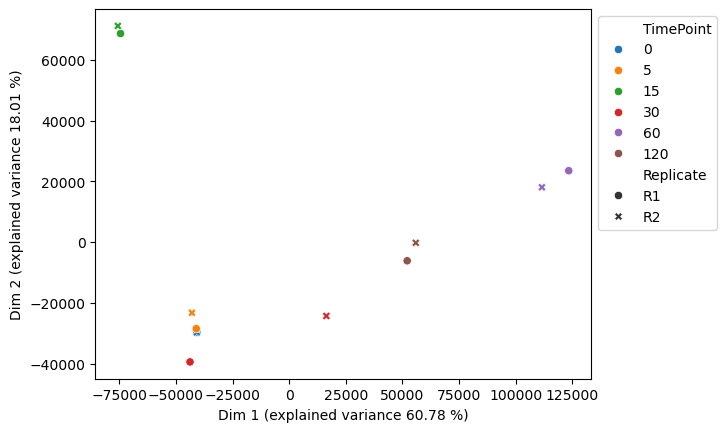

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

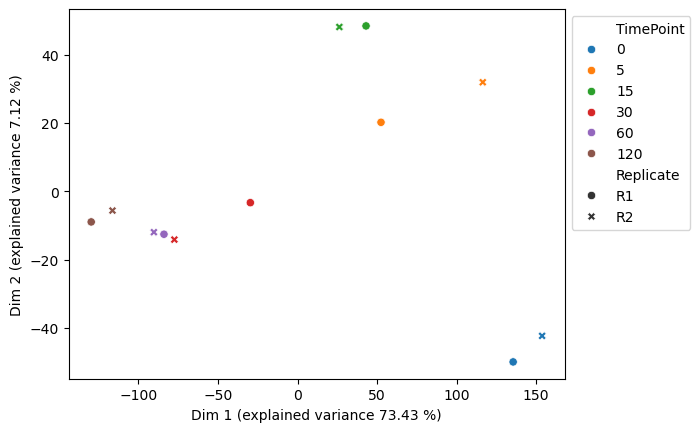

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

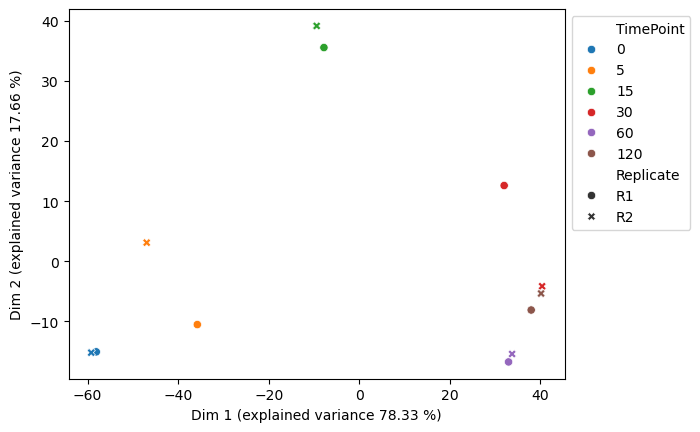

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks ok.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [30]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '5', '15', '30', '60', '120']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,5,15,30,60,120,Entity,Symbol
Geneid,,,,,,,,
gene-MSMEI_RS32130,6.733541,3.447788,4.251388,1.434927,1.745291,1.159574,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,75.744265,33.652403,3.346832,2.930288,5.877849,2.178149,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,8.351861,4.773732,2.507703,2.539196,1.683011,2.051942,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,4.075310,5.856375,2.394628,1.984619,1.793771,0.570823,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,17.472465,5.302500,1.567314,2.135623,2.277274,1.174557,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,645.259009,196.586489,47.294366,14.898557,10.795299,6.420826,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,78.070041,45.477307,14.707140,7.113772,3.171131,2.850124,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,2.278406,0.693156,1.092371,1.870839,0.733130,0.818630,host,gene-MSMEI_RS26155


In [31]:
TPMsds = TPMsds[['0', '5', '15', '30', '60', '120']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,5,15,30,60,120,Entity,Symbol
Geneid,,,,,,,,
gene-MSMEI_RS32130,1.451629,0.302722,1.513050,0.938873,0.637320,0.652963,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,15.782239,7.334170,2.431804,0.550642,1.897050,0.361148,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,1.675656,0.791669,0.892480,1.661397,0.277616,1.155460,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,1.748753,2.623945,0.419775,0.455119,0.655023,0.050139,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,8.292682,2.813710,0.557800,0.489748,1.398902,0.506348,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,190.037666,90.702571,0.742620,6.465639,7.471386,2.191573,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,22.013436,5.952960,9.731677,2.800664,1.157988,1.752353,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,1.793068,0.114952,0.388770,0.041035,0.120931,0.352909,host,gene-MSMEI_RS26155


In [32]:
propExp = proportionalExp(TPMmeans[['0', '5', '15', '30', '60', '120']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,5,15,30,60,120,Entity,Symbol
Geneid,,,,,,,,
gene-MSMEI_RS32130,1.000000,0.512032,0.631375,0.213101,0.259194,0.172209,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,1.000000,0.444290,0.044186,0.038687,0.077601,0.028757,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,1.000000,0.571577,0.300257,0.304028,0.201513,0.245687,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,0.695876,1.000000,0.408893,0.338882,0.306294,0.097470,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,1.000000,0.303477,0.089702,0.122228,0.130335,0.067223,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,1.000000,0.304663,0.073295,0.023089,0.016730,0.009951,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,1.000000,0.582519,0.188384,0.091120,0.040619,0.036507,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,1.000000,0.304228,0.479445,0.821118,0.321773,0.359300,host,gene-MSMEI_RS26155


## 5. Phage gene classification

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [34]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [35]:
TPMmeans

,0,5,15,30,60,120,Entity,Symbol
Geneid,,,,,,,,
gene-MSMEI_RS32130,6.733541,3.447788,4.251388,1.434927,1.745291,1.159574,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,75.744265,33.652403,3.346832,2.930288,5.877849,2.178149,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,8.351861,4.773732,2.507703,2.539196,1.683011,2.051942,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,4.075310,5.856375,2.394628,1.984619,1.793771,0.570823,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,17.472465,5.302500,1.567314,2.135623,2.277274,1.174557,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,645.259009,196.586489,47.294366,14.898557,10.795299,6.420826,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,78.070041,45.477307,14.707140,7.113772,3.171131,2.850124,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,2.278406,0.693156,1.092371,1.870839,0.733130,0.818630,host,gene-MSMEI_RS26155


In [36]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [37]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      34
early     27
middle    27
Name: count, dtype: int64

Add classes to other dfs.

In [38]:
gff3_genes["seq_id"].unique()

array(['NC_018289.1', 'KJ510414.1'], dtype=object)

In [39]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_018289.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'KJ510414.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [40]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [41]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,
gene-MSMEI_RS32130,5.281912,8.185169,3.145067,3.750510,5.764438,2.738338,2.373799,0.496054,1.107971,2.382611,0.506612,1.812537,host,gene-MSMEI_RS32130,None,None,1.556503
gene-MSMEI_RS09540,91.526505,59.962026,40.986574,26.318233,5.778636,0.915028,2.379646,3.480931,7.774900,3.980799,2.539298,1.817001,host,gene-MSMEI_RS09540,None,None,37.905702
gene-MSMEI_RS18000,6.676206,10.027517,5.565401,3.982063,3.400183,1.615223,4.200593,0.877800,1.960627,1.405395,0.896482,3.207402,host,gene-MSMEI_RS18000,None,None,1.859427
gene-MSMEI_RS33165,2.326557,5.824063,3.232430,8.480320,1.974854,2.814403,2.439738,1.529500,1.138748,2.448795,0.520684,0.620962,host,gene-MSMEI_RS33165,None,None,1.711148
gene-MSMEI_RS32755,9.179783,25.765148,8.116210,2.488789,2.125115,1.009514,2.625371,1.645875,3.676175,0.878372,1.680905,0.668209,host,gene-MSMEI_RS32755,None,None,9.259627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,835.296675,455.221343,105.883918,287.289060,48.036986,46.551747,21.364195,8.432918,3.323913,18.266684,8.612399,4.229253,host,gene-MSMEI_RS10270,None,None,391.438526
gene-MSMEI_RS20560,100.083477,56.056605,51.430268,39.524347,24.438817,4.975462,4.313109,9.914436,2.013144,4.329119,4.602477,1.097772,host,gene-MSMEI_RS20560,None,None,34.714387
gene-MSMEI_RS26155,4.071474,0.485339,0.808107,0.578204,1.481140,0.703601,1.829804,1.911875,0.854061,0.612199,1.171540,0.465721,host,gene-MSMEI_RS26155,None,None,0.768245


In [42]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,5_R1,5_R2,15_R1,15_R2,30_R1,30_R2,60_R1,60_R2,120_R1,120_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-MSMEI_RS32130,3,6,1,2,1,1,0,0,0,1,0,1,host,gene-MSMEI_RS32130
gene-MSMEI_RS09540,60,47,19,17,1,0,0,3,3,2,2,1,host,gene-MSMEI_RS09540
gene-MSMEI_RS18000,2,4,1,1,0,0,0,0,0,0,0,1,host,gene-MSMEI_RS18000
gene-MSMEI_RS33165,1,4,1,5,0,1,0,1,0,1,0,0,host,gene-MSMEI_RS33165
gene-MSMEI_RS32755,5,18,3,1,0,0,0,1,1,0,1,0,host,gene-MSMEI_RS32755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-MSMEI_RS10270,553,361,50,191,12,25,4,8,1,11,8,3,host,gene-MSMEI_RS10270
gene-MSMEI_RS20560,36,24,13,14,3,1,0,5,0,1,2,0,host,gene-MSMEI_RS20560
gene-MSMEI_RS26155,3,0,0,0,0,0,0,2,0,0,1,0,host,gene-MSMEI_RS26155


In [44]:
# Full TPM table
tpms.to_csv('Halleran_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Halleran_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Halleran_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Halleran_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Halleran_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Halleran_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Halleran_phage_gff3.tsv', sep='\t')